# 6.6: Sourcing & Analyzing Time Series Data

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Data

## 1. Importing libraries and data

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles statistical models.
import os
import warnings # This is a library that handles warnings.
import gc

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [3]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

In [4]:
# Configure API key 

quandl.ApiConfig.api_key = '_5rimxQ1A1zwxrR-EXrT'


In [5]:
# Importing the Natural Gas Price Index.

df = quandl.get('BCB/1402')

In [6]:
df.head()

,Value
Date,
1979-01-31,1038.0
1979-02-28,1030.0
1979-03-31,1057.0
1979-04-30,1044.0
1979-05-31,1038.0


In [7]:
df.tail()

,Value
Date,
2022-07-31,7164.0
2022-08-31,7303.0
2022-09-30,7393.0
2022-10-31,7483.0
2022-11-30,7721.0


In [8]:
df.shape

(527, 1)

In [9]:
df.columns

Index(['Value'], dtype='object')

In [10]:
type(df)

pandas.core.frame.DataFrame

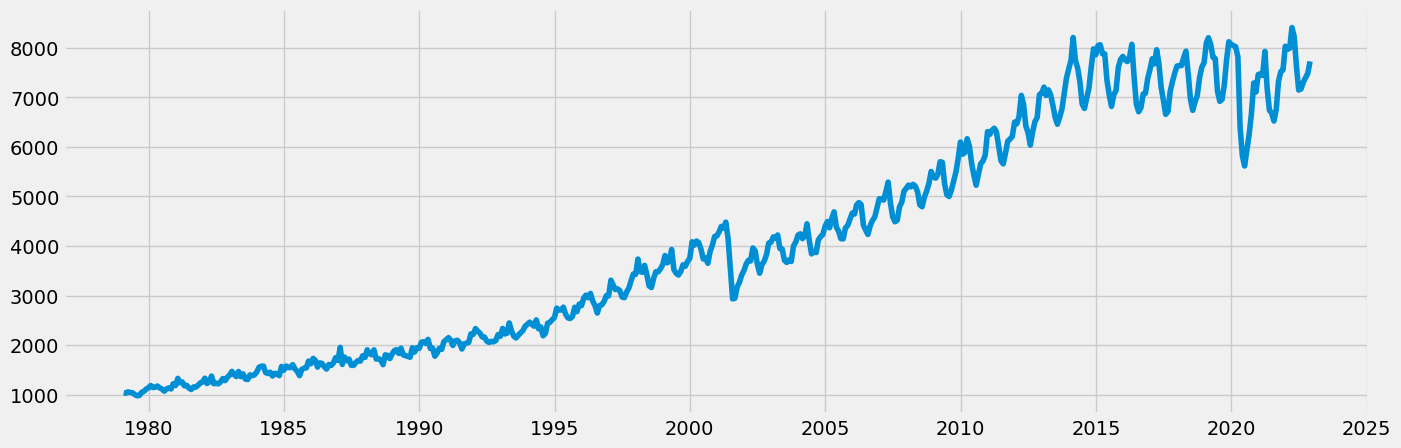

In [12]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df)

#### I have decided to use the data from 2000 as I believe they are more relevant.

### 2. Subsetting, wrangling, and cleaning time-series data

In [13]:
# Reset index so that you can use the "Date" column as a filter

df_2 = df.reset_index()

In [14]:
df_2.head(5)

,Date,Value
0,1979-01-31,1038.0
1,1979-02-28,1030.0
2,1979-03-31,1057.0
3,1979-04-30,1044.0
4,1979-05-31,1038.0


In [15]:
df_sub = df_2.loc[(df_2['Date'] >= '2000-01-01')]

In [16]:
df_sub.shape

(275, 2)

In [17]:
# Set the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Date']) # Create a datetime column from "Date.""
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,Value
datetime,
2000-01-31,4083.0
2000-02-29,4016.0
2000-03-31,4099.0
2000-04-30,4065.0
2000-05-31,3931.0


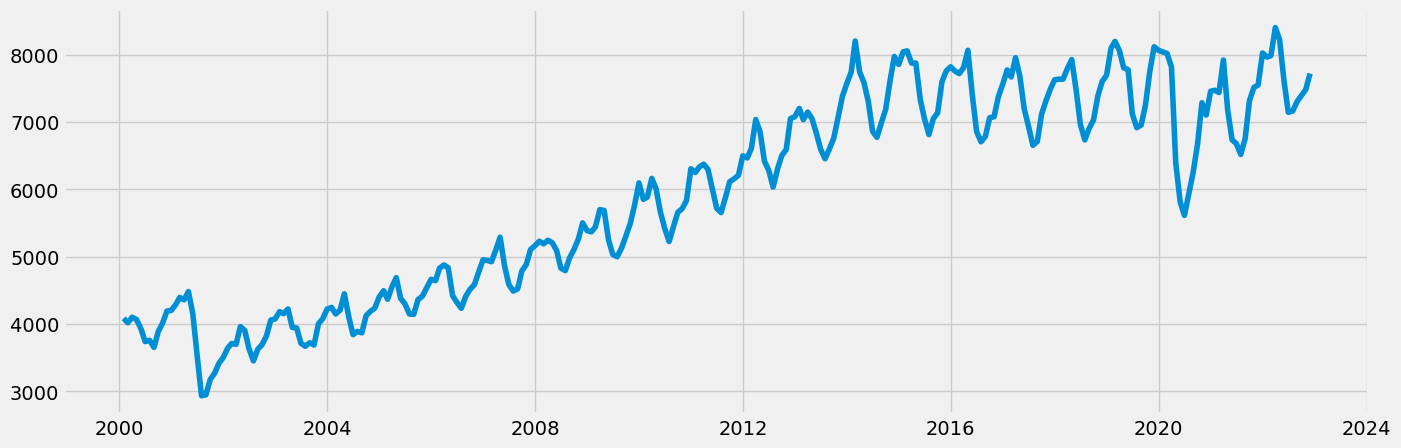

In [18]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_sub)

In [19]:
# Check for missing values 

df_sub.isnull().sum() # No missing values

Value    0
dtype: int64

### No missing values

In [32]:
# Check for dups

df_dups = df_sub.duplicated()
df_dups.sum()

8

### We have duplicates but they are only a few and probably it has to do with the fact that energy consuption can have the same values in more than one days. Thus, I have decided against removing those rows.

### 3. Time-series analysis: decomposition

Based on the pattern in the data, my inclination is that a multiplicative model would be more suitable for capturing the nonlinear trend. However, I would like to try both models and compare the results to see if there are any notable differences.

#### Additive Model

In [36]:
# Decompose the time series using an additive model

decomposition_adi = sm.tsa.seasonal_decompose(df_sub, model='additive') 

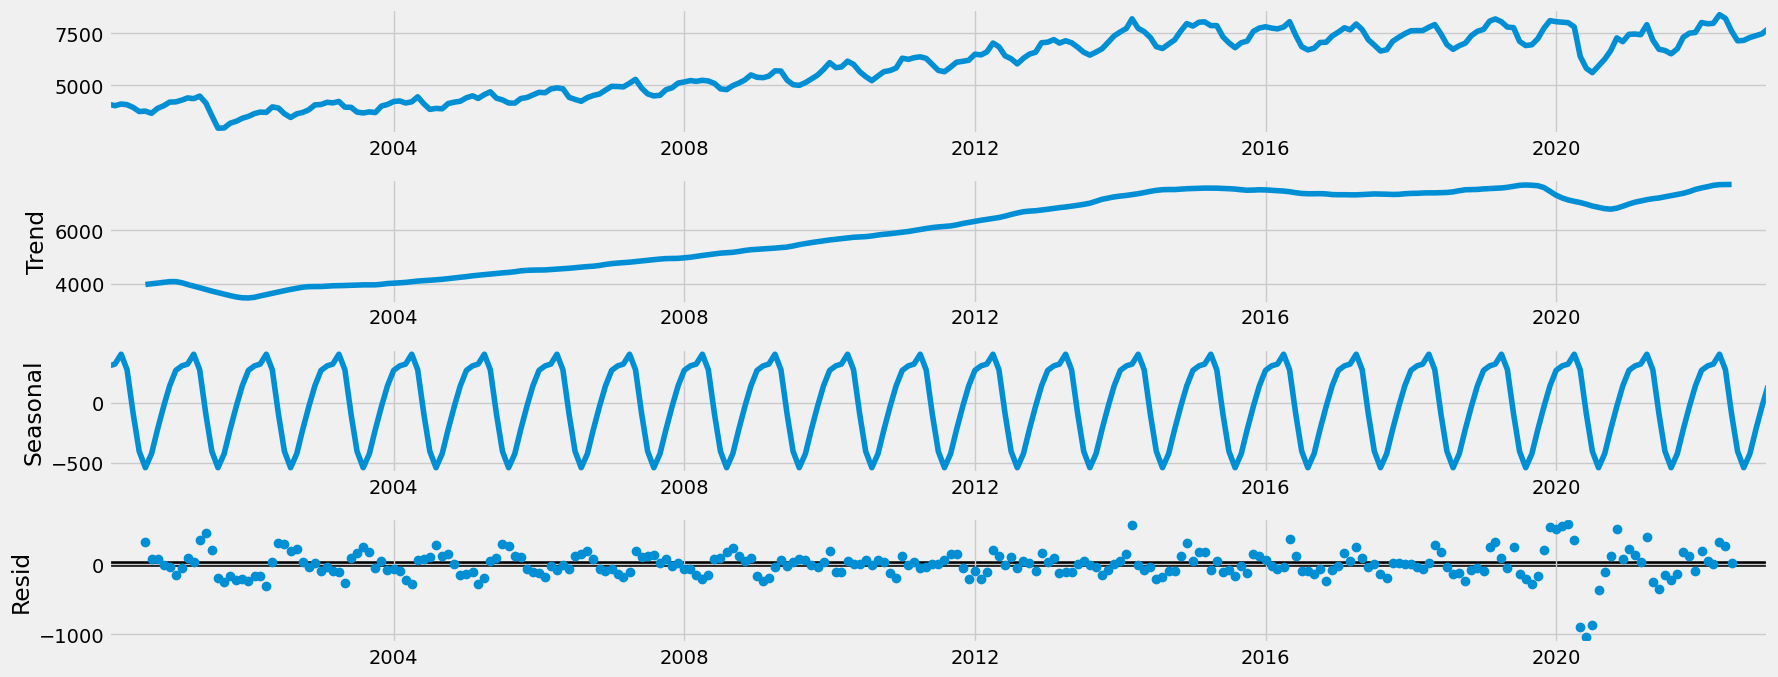

In [37]:
# Plot the separate components

decomposition_adi.plot()
plt.show()

#### Multiplicative Model

In [39]:
# Decompose the time series using an multiplicative model

decomposition_multi = sm.tsa.seasonal_decompose(df_sub, model='multiplicative') 

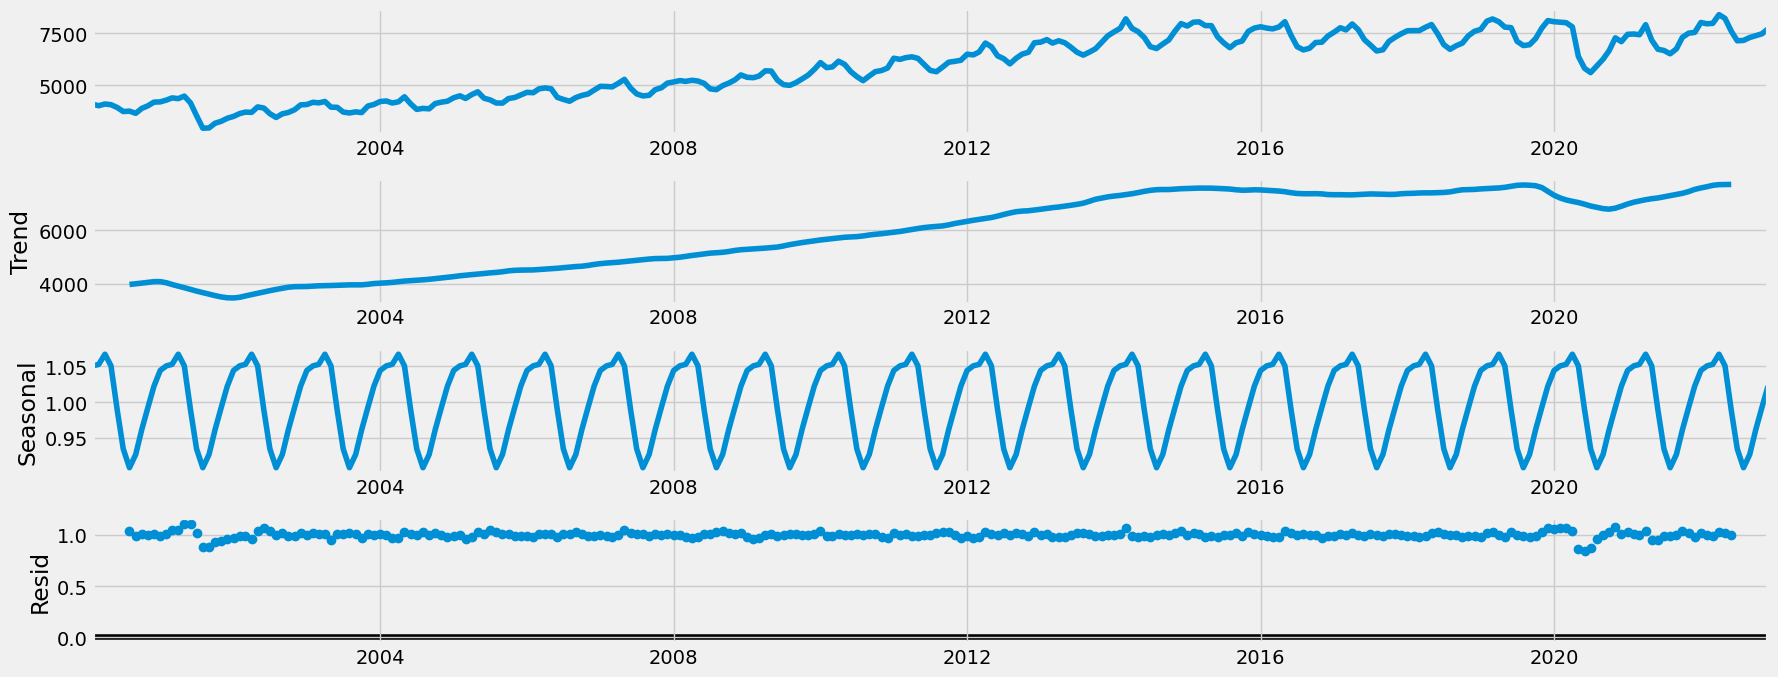

In [40]:
# Plot the separate components

decomposition_multi.plot()
plt.show()

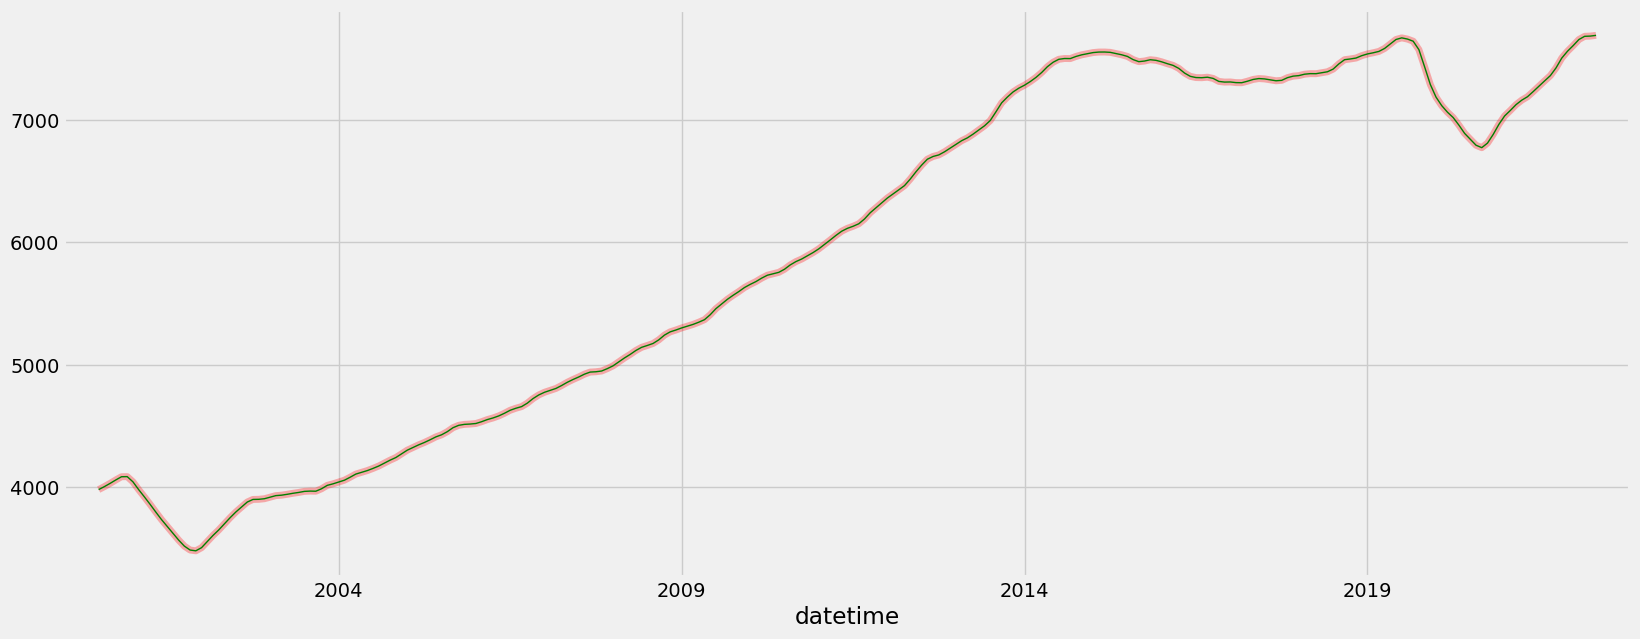

In [41]:
# Evaluating trends component from both models

decomposition_adi.trend.plot(color='red', linewidth=5, alpha=0.3)
decomposition_multi.trend.plot(color='green', linewidth=1)
plt.show()

After examining both plots, it appears that both capture similar patterns of trend and seasonality. The residual component from the additive model appears to have more dispersed areas, whereas the residual component from the multiplicative model has more consistent variance. This suggests that a multiplicative model is more suitable for this particular time series.

### 4. Testing for stationarity

In [42]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.672863
p-value                          0.853654
Number of Lags Used             13.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


With a significance level of 5%, the critical value is -2.872678. However, the test statistic value is -0.672863, which is greater than the critical value. This implies that the null hypothesis cannot be rejected, and there is a unit root in the data, indicating that it is non-stationary. The p-value of the test also supports this finding, as the p-value of 0.853654 is greater than the significance level of 0.05.

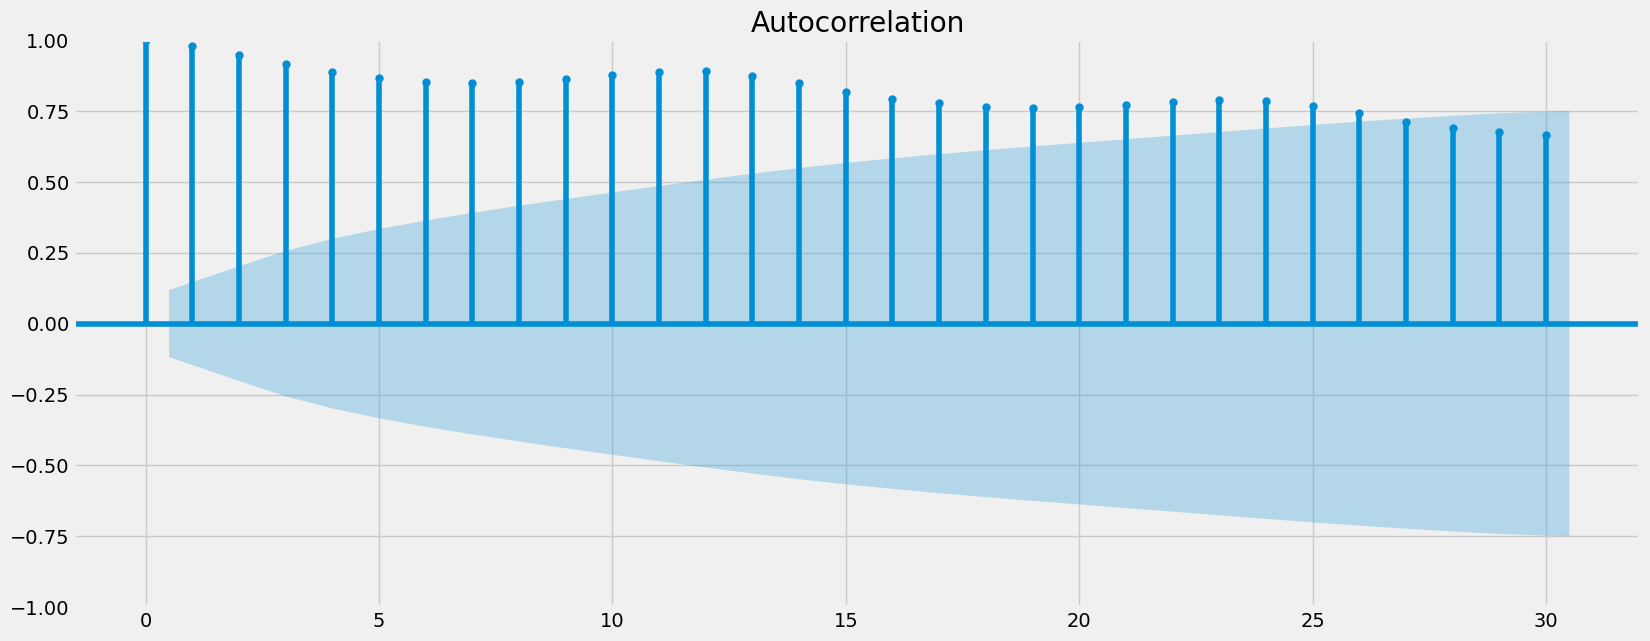

In [43]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sub, lags=30)
plt.show()

In [44]:
autocorr = acf(df_sub, alpha=0.05)

In [45]:
autocorr 

(array([1.        , 0.97970915, 0.94892574, 0.91655296, 0.88678569,
        0.8655239 , 0.85350594, 0.84972167, 0.85331867, 0.86420789,
        0.87758189, 0.88890807, 0.88954765, 0.8742021 , 0.84748775,
        0.81747983, 0.79329906, 0.77682877, 0.76533856, 0.76098816,
        0.76332415, 0.77018325, 0.78132528, 0.78841014, 0.78401106]),
 array([[1.        , 1.        ],
        [0.86151888, 1.09789943],
        [0.74697387, 1.15087762],
        [0.65976218, 1.17334374],
        [0.58776853, 1.18580286],
        [0.53178552, 1.19926228],
        [0.4897609 , 1.21725098],
        [0.45900127, 1.24044207],
        [0.43758518, 1.26905216],
        [0.4246884 , 1.30372738],
        [0.41493415, 1.34022963],
        [0.40356356, 1.37425258],
        [0.38197044, 1.39712486],
        [0.34529594, 1.40310826],
        [0.29876862, 1.39620687],
        [0.25077121, 1.38418845],
        [0.21035069, 1.37624742],
        [0.17899037, 1.37466718],
        [0.15356226, 1.37711486],
        [0.1

The vertical lines in the plot correspond to the lags in the series, while the blue area represents the confidence interval. Upon observation, it appears that most of the lags extend beyond the blue edge of the confidence interval, suggesting that there are significant correlations among the lags. This finding is consistent with the results of the Dickey-Fuller test we conducted earlier, which also pointed to the non-stationary nature of the data.


### 5. Stationarizing the Data

In [46]:
df_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [47]:
df_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [48]:
df_diff.head()

,Value
datetime,
2000-02-29,-67.0
2000-03-31,83.0
2000-04-30,-34.0
2000-05-31,-134.0
2000-06-30,-195.0


In [49]:
df_diff.columns

Index(['Value'], dtype='object')

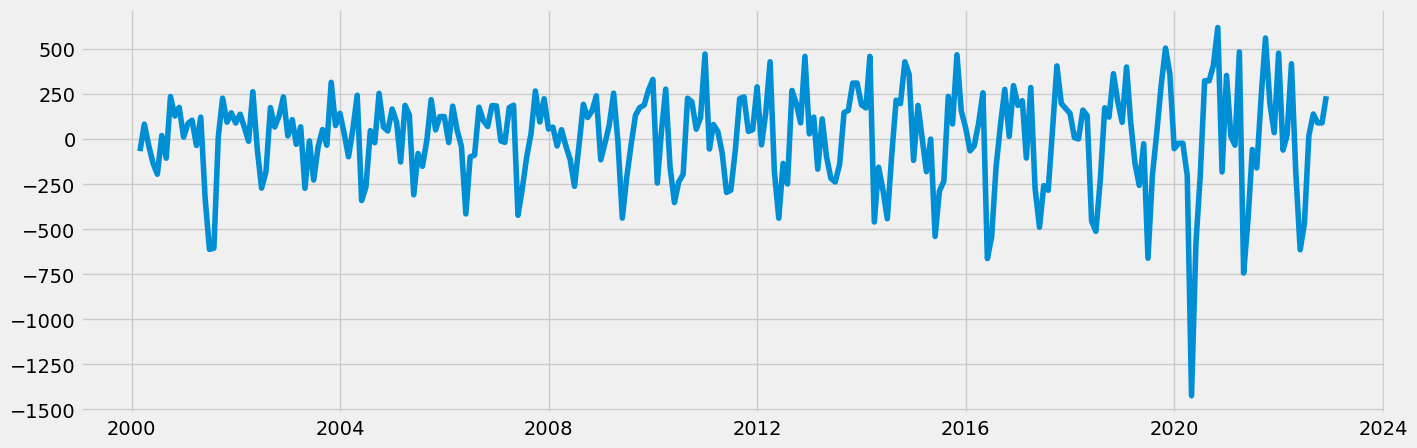

In [50]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [51]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.548922
p-value                          0.000160
Number of Lags Used             12.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


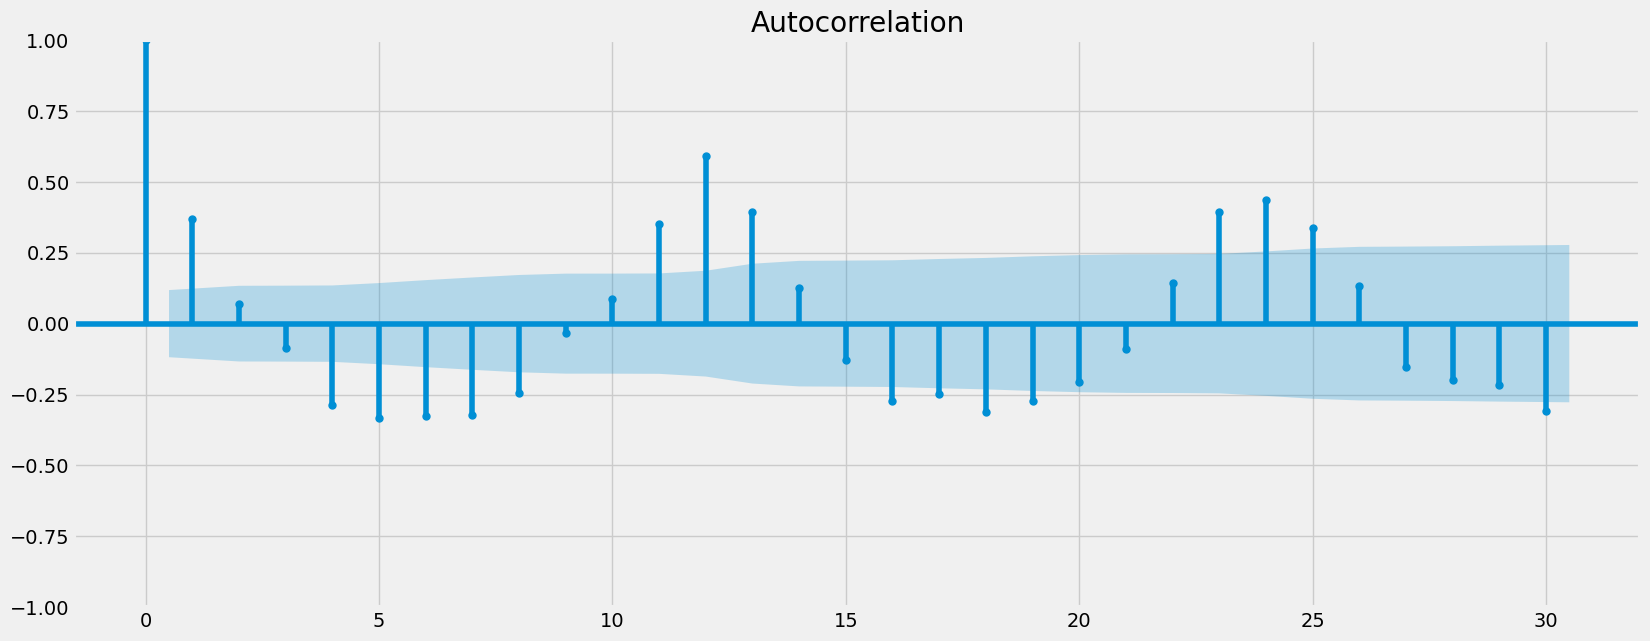

In [52]:
plot_acf(df_diff, lags=30)
plt.show()

Although the autocorrelation plot has improved, it is evident that the data is still not stationary. Specifically, there are high positive correlations at 1, 11, 12, 13,23, 24 and 25, and high negative correlations at 4,5,6,7,8,16,17,18,19 and 30, indicating the presence of seasonality in the data. However, it is worth noting that the Dickey-Fuller Stationarity test suggests that the time series is already stationary. It's possible that the test result is affected by the sample size or other factors, and it's important to consider multiple methods to ensure that the data is indeed stationary.